# NOAA gif generator

NOAA publishes the [ABI-L2-CMIPF](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C01502) dataset and its different bands in an S3 bucket that can be accessed with `rioxarray`.

This notebook generates a gif from frames in that dataset. It's structured to run as a workflow that creates custom gifs and to describe each step of methodology. The functionality of this workflow is also showcased as an interactive [Streamlit demo app](https://demo.fused.io/). 

In short, a user first defines the bounds an area of interest and date range, then runs the workflow to create a gif file. A Fused [UDF](https://docs.fused.io/) reads NOAA's S3 bucket in parallel, and this Notebook's stitches them together - at 6 frames per hour of data. All data is processed on the fly and can be cached for subsequent runs.

## 1. Housekeeping

This notebook calls two _User Defined Functions (UDFs)_ via the _Fused hosted API_ to fetch data and take advantage of cloud parallelization, then locally runs helper functions to stitch the returned arrays together into an exportable file. The Fused cloud is used for the execution advantages - and the code it runs is open and modifiable. You can view, run, and copy the two UDFs (named `GOES_18_Async` and `GOES_18_Partitions`) in the [Fused Workbench](https://app.fused.io/workbench), or within a Notebook cell as shown below.

The following housekeeping cells declare imports and authenticate with Fused API.

### 1.1 Imports

In [ ]:
!pip3 install fused==1.1.4 geopandas imageio ipywidgets shapely

In [1]:
import base64
import datetime
import json
from typing import Any, List

import geopandas as gpd
import imageio
import ipywidgets as widgets
import numpy as np
from IPython.display import Image
from shapely.geometry import Polygon

import fused
from fused import NotebookCredentials

fused.options.request_timeout = 120

### 1.2 Authenticate

In [2]:
# To authenticate to the Fused API, copy the token from the URL shown in this cell's output
credentials = NotebookCredentials()


Please open this link to authenticate with Fused:

* [https://dev-tjcykxcetrz6bps6.us.auth0.com/authorize?audience=fused-python-api&scope=openid+email+name+offline_access&response_type=code&client_id=CXiwKZQmmyo0rqXZY7pzBgfsF7AL2A9l&redirect_uri=https%3A%2F%2Fapp.fused.io%2Fnotebook_login_redirect&code_challenge_method=S256&code_challenge=1uVlntkglPd87eZGDEmw4c2q2vAxVMi0ubAjEN7FfTQ](https://dev-tjcykxcetrz6bps6.us.auth0.com/authorize?audience=fused-python-api&scope=openid+email+name+offline_access&response_type=code&client_id=CXiwKZQmmyo0rqXZY7pzBgfsF7AL2A9l&redirect_uri=https%3A%2F%2Fapp.fused.io%2Fnotebook_login_redirect&code_challenge_method=S256&code_challenge=1uVlntkglPd87eZGDEmw4c2q2vAxVMi0ubAjEN7FfTQ)

Once you have logged in, that page will give you a code which you can paste into this notebook to finish logging in.


☝️ Pro-tip: with VSCode, if cell outputs don't render as you might expect, you can configure the cell's output.

<img src="https://fused-magic.s3.us-west-2.amazonaws.com/docs_assets/git_workflow_config_cell_output.png" width="40%" />


In [3]:
# You should paste here token from the URL above and run the cell
# credentials.finalize(code="...")

## 2. Define input parameters to customize gif

### 2.1 Set datetime range

In [4]:
# Set date & time
EST = datetime.timezone(
    datetime.timedelta(hours=-5)
)  # Eastern Standard Time (EST) is UTC-5
DEFAULT_DATETIME = datetime.datetime(2024, 2, 6, 12, 0, tzinfo=EST)

selected_datetime = widgets.DatetimePicker(
    description="Start Time", value=DEFAULT_DATETIME, disabled=False
)

# Set number of frames after start time (6 frames correspond to 1 hour)
n_frames = widgets.IntText(
    value=32, description="N Frames", min=1, max=720, step=1, disabled=False
)

# File name of generated gif
gif_file_name = widgets.Text(
    value="/tmp/animation.gif",
    placeholder="/tmp/animation.gif",
    description="Output file",
    disabled=False,
)

# Display
widgets.VBox([selected_datetime, n_frames, gif_file_name])

### 2.2 Set bounds for area of interest (AOI)

The AOI should be defined in a 1-row GeoDataFrame with a single `geometry` column.

In [5]:
# Sample geometry and crs
roi_wkt = '{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"location": "OR_ABI-L2-CMIPF-M6C09_G18_s20240290000212_e20240290009526_c20240290009593.nc_colored.tif"}, "geometry": {"type": "Polygon", "coordinates": [[[-4000000.0, 2500000.0], [3000000.0, 2500000.0], [3000000.0, -1500000.0], [-4000000.0, -1500000.0], [-4000000.0, 2500000.0]]]}}]}'
crs = 'PROJCRS["WGS84 / Lambert_Conformal_Conic_2SP",BASEGEOGCRS["WGS84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]]],CONVERSION["unnamed",METHOD["Lambert Conic Conformal (2SP)",ID["EPSG",9802]],PARAMETER["Latitude of false origin",33,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8821]],PARAMETER["Longitude of false origin",-125,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8822]],PARAMETER["Latitude of 1st standard parallel",21,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Latitude of 2nd standard parallel",45,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8824]],PARAMETER["Easting at false origin",0,LENGTHUNIT["Meter",1],ID["EPSG",8826]],PARAMETER["Northing at false origin",0,LENGTHUNIT["Meter",1],ID["EPSG",8827]]],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["Meter",1]],AXIS["northing",north,ORDER[2],LENGTHUNIT["Meter",1]]]'
json_data = json.loads(roi_wkt)

# Input geodataframe
roi = gpd.GeoDataFrame(
    geometry=[
        Polygon(feature["geometry"]["coordinates"][0])
        for feature in json_data["features"]
    ],
    crs=crs,
)
roi

,geometry
0,"POLYGON ((-4000000.000 2500000.000, 3000000.00..."


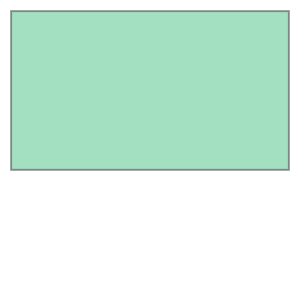

In [6]:
roi.geometry.iloc[0]

## 3. Generate frames from band 8 of the GOES-18 dataset

The next cell declares and previews function to call the UDF that returns the data as an array.

The subsequent cells create parallel calls, then stitch returned arrays to create the gif.

### 3.1 Structure parameters

In [7]:
# Set parameters to call the UDF
datestr: str = selected_datetime.value.strftime("%Y-%m-%d")
start_i: int = 0
end_i: int = n_frames.value  # Number of frames at 10-minute intervals after start time
band: int = 8  # Target band in the GOES-18 datasets
product_name: str = "ABI-L2-CMIPF"  # Imagery product in NOAA's S3 bucket

# Geometry in serializable representation
roi_wkt = roi.geometry.buffer(-90001).to_json()
crs = str(roi.crs)

### 3.2 Define and preview functions that create the array from NOAA imagery 🛰️

🎓 The `call_udf` structures calls to the remote UDF with the convenient `fused.core.run_file` wrapper. The appendix shows how to view and modify the Python code behind that UDF.

#### 3.2.1 UDF to determine how to subsample array
The first UDF call, to the UDF named `GOES_18_Partitions`, generates array coordinates to subsample NOAA image to the size of the original geometry.

In [ ]:
df = fused.core.run_file("sina@fused.io", "GOES_18_Partitions")
partition_str = df.to_json()
partition_str

'{"x_start":{"0":1190,"1":2380,"2":3570,"3":1190,"4":2380,"5":3570},"x_stop":{"0":2390,"1":3580,"2":4770,"3":2390,"4":3580,"5":4770},"y_start":{"0":0,"1":0,"2":0,"3":1190,"4":1190,"5":1190},"y_stop":{"0":1200,"1":1200,"2":1200,"3":2390,"4":2390,"5":2390},"fused_index":{"0":0,"1":1,"2":2,"3":3,"4":4,"5":5}}'

#### 3.2.2 UDF to subsample array
The second UDF call, to the UDF named `GOES_18_Async`, subsamples the array and returns an array that corresponds to different frames for the gif to generate. It's wrapped in the `call_udf` function to make it easy to run in a loop.

In [9]:
def call_udf(
    start_end_i: List[int] = [0, 32],
    band: int = 8,
    datestr: str = datestr,
    product_name: str = "ABI-L2-CMIPF",
    roi_wkt: str = '{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-4000000.0, 2500000.0], [3000000.0, 2500000.0], [3000000.0, -1500000.0], [-4000000.0, -1500000.0], [-4000000.0, 2500000.0]]]}}]}',
    crs: str = 'PROJCRS["WGS84 / Lambert_Conformal_Conic_2SP",BASEGEOGCRS["WGS84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]]],CONVERSION["unnamed",METHOD["Lambert Conic Conformal (2SP)",ID["EPSG",9802]],PARAMETER["Latitude of false origin",33,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8821]],PARAMETER["Longitude of false origin",-125,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8822]],PARAMETER["Latitude of 1st standard parallel",21,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Latitude of 2nd standard parallel",45,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8824]],PARAMETER["Easting at false origin",0,LENGTHUNIT["Meter",1],ID["EPSG",8826]],PARAMETER["Northing at false origin",0,LENGTHUNIT["Meter",1],ID["EPSG",8827]]],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["Meter",1]],AXIS["northing",north,ORDER[2],LENGTHUNIT["Meter",1]]]',
    partition_str: str = '{"x_start":{"0":1190,"1":2380,"2":3570,"3":1190,"4":2380,"5":3570},"x_stop":{"0":2390,"1":3580,"2":4770,"3":2390,"4":3580,"5":4770},"y_start":{"0":0,"1":0,"2":0,"3":1190,"4":1190,"5":1190},"y_stop":{"0":1200,"1":1200,"2":1200,"3":2390,"4":2390,"5":2390},"fused_index":{"0":0,"1":1,"2":2,"3":3,"4":4,"5":5}}',
) -> List[Any]:
    """
    Executes a remote user-defined function (UDF) to process satellite imagery data based on the given parameters.

    Args:
        start_end_i (int): The start & end indices for the imagery frames to process.
        band (int, optional): The satellite imagery band to process. Defaults to 8.
        datestr (str): The date string representing the target date for the satellite imagery data.
        product_name (str, optional): The name of the satellite imagery product. Defaults to "ABI-L2-CMIPF".
        roi_wkt (str, optional): A string representing the region of interest (ROI) in Well-Known Text (WKT) format for GeoJSON.
        crs (str, optional): The Coordinate Reference System (CRS) for the ROI.
        partition_str (str, optional): A string representing partition information for processing.

    Returns:
        List[Any]: A flattened list representing the processed image frames.

    This function calls a remote UDF, passing parameters for the date, index range, band, and imagery product name,
    and returns a list containing processed satellite imagery data.
    """
    start_i = start_end_i[0]
    end_i = start_end_i[1]
    df = fused.core.run_file(
        "sina@fused.io",  # This public UDF is published under Sina's account and available to all users
        "GOES_18_Async",  # Name of UDF
        datestr=datestr,
        start_i=start_i,
        end_i=end_i,
        band=band,
        product_name=product_name,
        roi_wkt=roi_wkt,
        crs=crs,
        partition_str=partition_str,
    )
    arr = df["arr"].apply(lambda x: x.reshape(df["shape"][0]))[0]
    return arr


# Call the UDF to preview its output array
arr = call_udf([start_i, end_i])

# Display the array shape and preview the first and last frames
print(
    f"The array shape is {arr.shape} which represents {end_i-start_i} frames of m x n pixels each."
)

i = 1  # Number of frames to preview from start and end of array
print("Array:\n", np.concatenate([arr[:i], arr[-i:]], axis=0))

The array shape is (32, 998, 1748) which represents 32 frames of m x n pixels each.
Array:
 [[[147 148 149 ... 116 116 116]
  [148 149 149 ... 116 116 116]
  [148 148 150 ... 116 116 116]
  ...
  [222 223 223 ... 246 245 246]
  [223 223 224 ... 246 246 246]
  [224 224 224 ... 246 246 246]]

 [[123 124 124 ...  84  83  84]
  [122 124 123 ...  85  85  85]
  [118 122 121 ...  86  86  87]
  ...
  [204 213 213 ... 250 250 249]
  [213 212 212 ... 250 250 249]
  [211 209 210 ... 250 250 250]]]


### 3.3 Now run in parallel ⚡

In [10]:
def run_async(fn, arr_args):
    """
    Runs an asynchronous function concurrently for each set of arguments in a list.

    This function takes an asynchronous function `fn` and a list of arguments `arr_args`.
    Each set of arguments in `arr_args` is passed to `fn`, and all the calls are executed concurrently.
    It uses `asyncio.to_thread` to run the asynchronous tasks in separate threads, allowing for
    concurrent execution even if the tasks are CPU-bound.

    Parameters:
    - fn (Callable[[Any], Coroutine[Any, Any, Any]]): An asynchronous function to be executed concurrently.
      The function should accept a single argument and return a coroutine.
    - arr_args (List[Any]): A list of arguments to be passed to `fn`. Each element in the list is a set of
      arguments for a single execution of `fn`.

    Returns:
    - List[Any]: A list of results from the concurrent execution of `fn` with each set of arguments from `arr_args`.

    Note:
    This function applies `nest_asyncio.apply()` to allow the event loop to be nested. This is useful for
    running asyncio applications in environments where an event loop is already running, such as Jupyter notebooks.
    """
    import asyncio

    import nest_asyncio

    nest_asyncio.apply()
    a = []
    for i in arr_args:
        a.append(asyncio.to_thread(fn, i))

    async def main():
        return await asyncio.gather(*a)

    return asyncio.run(main())

In [19]:
# Break-up the input arguments into individual chunks
BLOCK_SIZE = 12  # Number of frames to process in each call to the UDF
L = np.arange(start_i, end_i, BLOCK_SIZE)
arg_list = [[i, i + BLOCK_SIZE] for i in L[:-1]] + [(L[-1], end_i)]
arg_list

[[0, 12], [12, 24], (24, 32)]

In [12]:
# Call the UDF for each chunk of input arguments
frames = run_async(call_udf, arg_list)

# Stack frames 🥞
frames_raw = np.vstack(frames)

## 4. Stitch gif
The cell above made an array of `k` x `m` x `n` dimensions, where `k` is the number of frames, and `m` & `n` are the vertical and horizontal dimensions of the image. The next step stitches these together to create a gif.

In [13]:
def to_gif(
    frames: List[np.ndarray], file_name: str, duration: int = 150, loop: int = 1000
) -> str:
    """
    Converts a list of image frames into a GIF and returns a base64-encoded data URL of the GIF.

    This function processes each frame to clip and stretch its pixel values to the 0-255 range,
    compiles these frames into a GIF file saved to the specified file name, and then encodes the
    file's contents into a base64 data URL.

    Parameters:
    - frames (List[np.ndarray]): A list of image frames, where each frame is represented as a NumPy
      array of pixel values.
    - file_name (str): The name of the file where the GIF should be saved.
    - duration (int, optional): The duration (in milliseconds) of each frame in the GIF. Default is 150ms.
    - loop (int, optional): The number of times the GIF should loop. Default is 1000, where 0 means
      an infinite loop.

    """

    def _func(frame: np.ndarray) -> np.ndarray:
        min_val = 0
        max_val = 255
        arr = np.array(frame)
        arr_clipped = np.clip(arr, min_val, max_val)
        arr_stretched = ((arr_clipped - min_val) / (max_val - min_val) * 255).astype(
            "uint8"
        )
        return arr_stretched

    frames = [_func(arr) for arr in frames]
    imageio.mimsave(file_name, frames, format="GIF", duration=duration, loop=loop)

    with open(file_name, "rb") as file_:
        contents = file_.read()
        data_url = base64.b64encode(contents).decode("utf-8")

In [ ]:
# Configure output gif
gif_duration = 20  # Between 20 and 100 seconds
coarsen = 1  # Between 1 and 5. Reduces file size, take every second pixel in the x & y directions.
gif_slice = slice(0, 1000, 1)

# Structure gif
frames_gif = [i[::coarsen, ::coarsen] for i in frames_raw]
_ = to_gif(frames_gif[gif_slice], gif_file_name.value, duration=gif_duration)

# Display gif
display(Image(filename=gif_file_name.value))

<img src="https://fused-magic.s3.us-west-2.amazonaws.com/docs_assets/gifs/animation.gif" width="40%" />

# Appendix I: View and modify UDF code

The 2 UDFs above are published under Sina's account. You can load them into your notebook with `get_udfs` then show code with `render`.

In [23]:
# Note: may require text/html "presentation" on VSCODE to show repr
my_udf_goes_18_partitions = fused.get_udfs(whose="public")["GOES_18_Partitions"]
my_udf_goes_18_partitions

GeoPandasUdfV2Callable(name='GOES_18_Partitions', type=<UdfType.GEOPANDAS_V2: 'geopandas_v2'>, code='#TODO make sure do not cache the future\n# https://noaa-goes18.s3.amazonaws.com/index.html#ABI-L1b-RadC/2024/001/00/\n@fused.udf\ndef udf(url=\'https://noaa-goes18.s3.amazonaws.com/ABI-L2-CMIPF/2024/031/01/OR_ABI-L2-CMIPF-M6C08_G18_s20240310140216_e20240310149524_c20240310149597.nc\',\n        roi_wkt = \'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-4100000.0, 2400000.0], [3200000.0, 2400000.0], [3200000.0, -1500000.0], [-4100000.0, -1500000.0], [-4100000.0, 2400000.0]]]}}]}\',\n        crs = \'PROJCRS["WGS84 / Lambert_Conformal_Conic_2SP",BASEGEOGCRS["WGS84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]]],CONVERSION["unnamed",METHOD["Lambert Conic Conformal (2SP)",ID["EPSG",9802]],PARAMETER["Latitude of false origin",33,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8821]],PARAMETER["Longitude of false origin",-125,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8822]],PARAMETER["Latitude of 1st standard parallel",21,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Latitude of 2nd standard parallel",45,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8824]],PARAMETER["Easting at false origin",0,LENGTHUNIT["Meter",1],ID["EPSG",8826]],PARAMETER["Northing at false origin",0,LENGTHUNIT["Meter",1],ID["EPSG",8827]]],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["Meter",1]],AXIS["northing",north,ORDER[2],LENGTHUNIT["Meter",1]]]\',\n        chunk_len=1200): \n    chunk_size = (int(chunk_len), int(chunk_len))\n    import geopandas as gpd\n    import pandas as pd\n    from shapely.geometry import Polygon \n    import json\n    json_data = json.loads(roi_wkt)\n    roi = gpd.GeoDataFrame(geometry=[Polygon(feature["geometry"]["coordinates"][0]) for feature in json_data["features"]]\n                               ,crs=crs)\n    @fused.cache\n    def cache_valid_list(roi, url, chunk_size): \n        from utils import chunkify, roi_ds_chunks\n        import rioxarray\n        xds = rioxarray.open_rasterio(url)\n        xy_size = (len(xds.x),len(xds.y))\n        slice_list = chunkify(chunk_size=chunk_size, xy_size=xy_size, pad=10)\n        valid_list = roi_ds_chunks(roi, xds, slice_list, return_data=False) \n        return valid_list  \n    chunks=cache_valid_list(roi, url, chunk_size)  \n    df = pd.DataFrame([[i[0].start, i[0].stop, i[1].start, i[1].stop] for i in chunks], columns =[\'x_start\',\'x_stop\', \'y_start\',\'y_stop\'])\n    return df', headers=HeaderSequence(__root__=[Header(module_name='utils', source_code='def chunkify(chunk_size, xy_size, pad=10):\n    """\n    e.g. slice_list = chunkify(chunk_size=(500,500), xy_size=(1200,2000), pad=10)\n    """\n    x_len, y_len = xy_size\n    # Calculate the number of chunks along each dimension\n    n_chunks_x = x_len // (chunk_size[1] - pad) + 1\n    n_chunks_y = y_len // (chunk_size[0] - pad) + 1\n    xy_slices = []\n    # Create chunks\n    for i in range(n_chunks_y):\n        for j in range(n_chunks_x):\n            start_idx_x = j * (chunk_size[1] - pad)\n            end_idx_x = min(start_idx_x + chunk_size[1], x_len)\n            start_idx_y = i * (chunk_size[0] - pad)\n            end_idx_y = min(start_idx_y + chunk_size[0],  y_len)\n            xy_slices.append([slice(start_idx_x,end_idx_x), slice(start_idx_y,end_idx_y)])\n    return xy_slices\n\ndef roi_ds_chunks(roi, xds, slice_list, valid_list=[], return_data=True):\n    import numpy as np\n    if len(valid_list)>0:\n        slice_list=valid_list\n    ds_list=[]\n    for xy_slice in slice_list:\n        try:\n            ds = xds.isel(x=xy_slice[0], y=xy_slice[1])\n            ds_list.append(ds.rio.reproject(roi.crs).rio.clip(roi.geometry))\n            if xy_slice not in v

In [16]:
my_udf_goes_18_async = fused.get_udfs(whose="public")["GOES_18_Async"]
my_udf_goes_18_async

GeoPandasUdfV2Callable(name='GOES_18_Async', type=<UdfType.GEOPANDAS_V2: 'geopandas_v2'>, code='@fused.udf\ndef udf(roi_wkt = \'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-4100000.0, 2400000.0], [3200000.0, 2400000.0], [3200000.0, -1500000.0], [-4100000.0, -1500000.0], [-4100000.0, 2400000.0]]]}}]}\',\n        crs = \'PROJCRS["WGS84 / Lambert_Conformal_Conic_2SP",BASEGEOGCRS["WGS84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]]],CONVERSION["unnamed",METHOD["Lambert Conic Conformal (2SP)",ID["EPSG",9802]],PARAMETER["Latitude of false origin",33,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8821]],PARAMETER["Longitude of false origin",-125,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8822]],PARAMETER["Latitude of 1st standard parallel",21,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Latitude of 2nd standard parallel",45,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8824]],PARAMETER["Easting at false origin",0,LENGTHUNIT["Meter",1],ID["EPSG",8826]],PARAMETER["Northing at false origin",0,LENGTHUNIT["Meter",1],ID["EPSG",8827]]],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["Meter",1]],AXIS["northing",north,ORDER[2],LENGTHUNIT["Meter",1]]]\', \n        partition_str = \'{"x_start":{"0":1190,"1":2380,"2":3570,"3":1190,"4":2380,"5":3570},"x_stop":{"0":2390,"1":3580,"2":4770,"3":2390,"4":3580,"5":4770},"y_start":{"0":0,"1":0,"2":0,"3":1190,"4":1190,"5":1190},"y_stop":{"0":1200,"1":1200,"2":1200,"3":2390,"4":2390,"5":2390},"fused_index":{"0":0,"1":1,"2":2,"3":3,"4":4,"5":5}}\',\n        datestr=\'2024-02-05\', start_i=0, end_i=6 , band=8, product_name=\'ABI-L2-CMIPF\'):\n    start_i=int(start_i); end_i=int(end_i); band=int(band);\n    from utils import frame_cache\n    import pandas as pd\n    import numpy as np\n    frames = frame_cache(partition_str, roi_wkt, crs, datestr, start_i, end_i, band=band, product_name=product_name)\n    frames_raw=[i.image.values[1:-1,1:-1] for i in frames if i is not None]\n    print(len(frames_raw))\n    frames_all = np.stack(frames_raw) \n    df = pd.DataFrame({\'arr\': [frames_all.flatten()]})\n    df[\'shape\'] = [frames_all.shape] \n    return df\n## how to use: \n# df = fused.utils.run_file("sina@fused.io", "geos_18_async", )\n# arr = df[\'arr\'].apply(lambda x: x.reshape(df[\'shape\'][0]))[0]', headers=HeaderSequence(__root__=[Header(module_name='utils', source_code='import fused\ndef run_async(fn, arr_args):\n    import asyncio\n    import nest_asyncio\n    nest_asyncio.apply()    \n    a=[]\n    for i in arr_args:\n        a.append(asyncio.to_thread(fn, i))\n    async def main(): \n        return await asyncio.gather(*a)\n    return asyncio.run(main())\n \ndef runner(params):\n    try:\n        i=params[\'i\'] \n        datestr=params[\'datestr\'] \n        band=params[\'band\']\n        product_name=params[\'product_name\']\n        roi_wkt=params[\'roi_wkt\']\n        crs=params[\'crs\']\n        partition_str=params[\'partition_str\']\n        return fused.utils.run_file("sina@fused.io", "GOES_18_Runner", product_name=product_name, \n                                        i=i, datestr=datestr, band=band, roi_wkt=roi_wkt, crs=crs, partition_str=partition_str)\n    except: return None\ndef frame_cache(partition_str, roi_wkt, crs, datestr, start_i, end_i, band=8, product_name=\'ABI-L2-CMIPF\'):\n    arg_list=[{\'i\':i, \'datestr\':datestr, \'band\':band, \'product_name\':product_name, \'crs\':crs, \'roi_wkt\':roi_wkt, \'partition_str\':partition_str} \n            for i in range(start_i, end_i)]\n    return run_async(runner, arg_list)', source_file=None)]), metadata={'fused:vizConfig': {'tileLayer': {'@@type': 'TileLayer', 'minZoom': 0, 'maxZoom': 19, 'tileSize': 256, 'pickable': True}, 'rasterLayer': {'@@type': 'BitmapLayer', 'p

In [24]:
# (Optionally) Render the UDF's code in a new notebook cell
# my_udf_goes_18_partitions.render()